In [61]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [27]:
df = pd.read_csv("Hitters.csv")


In [28]:
display("Initial shape:", df.shape)

display("Null Value Count")
display(df.isnull().sum())

# Drop rows with missing Salary (only variable with NAs)
df = df.dropna()
display("After drop:", df.shape)

# Reset index
df = df.reset_index(drop=True)

'Initial shape:'

(322, 20)

'Null Value Count'

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

'After drop:'

(263, 20)

In [29]:
X = df.drop(columns=["Salary"])
y = df["Salary"]

In [30]:
num_sel = make_column_selector(dtype_include=np.number)
cat_sel = make_column_selector(dtype_exclude=np.number)

num_cols = num_sel(X)
cat_cols = cat_sel(X)

In [31]:
display("Categorical columns:", cat_cols)
display("Numeric columns:", num_cols)

'Categorical columns:'

['League', 'Division', 'NewLeague']

'Numeric columns:'

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Scale numeric features, one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_cols)
    ],
    remainder="passthrough"
)


In [34]:
def cv_mse(pipeline, Xtr, ytr, cv=5):
    scores = cross_val_score(pipeline, Xtr, ytr, cv=KFold(cv, shuffle=True, random_state=42),
                             scoring="neg_mean_squared_error", n_jobs=-1)
    return -scores.mean(), scores.std()

def evaluate_full(pipeline, X_train, X_test, y_train, y_test, name="model"):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    return {
        "Model": name,
        "R2_test": r2_score(y_test, y_pred),
        "RMSE_test": rmse,
        "MAE_test": mae
    }

In [35]:
def get_feature_names(fitted_pipe):
        ct = fitted_pipe.named_steps["preprocessor"]
        return ct.get_feature_names_out()

In [36]:
def top_coeff_table(fitted_pipe, top_k=10):
    names = get_feature_names(fitted_pipe)
    coefs = fitted_pipe.named_steps["model"].coef_
    dfc = pd.DataFrame({"Feature": names, "Coefficient": coefs})
    dfc["AbsCoef"] = dfc["Coefficient"].abs()
    return dfc.sort_values("AbsCoef", ascending=False).head(top_k).drop(columns="AbsCoef")

# Part I: Different Model Specs


### A. Regression without regularization
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [37]:
ols_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

ols_cv_mse_mean, ols_cv_mse_sd = cv_mse(ols_pipe, X_train, y_train, cv=5)
ols_results = evaluate_full(ols_pipe, X_train, X_test, y_train, y_test, "OLS")



In [38]:
display(f"[OLS] CV MSE: {ols_cv_mse_mean} (± {ols_cv_mse_sd})")
display(ols_results)

'[OLS] CV MSE: 148524.4273448546 (± 88857.66290489696)'

{'Model': 'OLS',
 'R2_test': 0.4110795465741335,
 'RMSE_test': np.float64(357.05329094607333),
 'MAE_test': 216.23960331813112}

In [39]:
ols_pipe.fit(X, y)
# names after preprocessing
feat_names_all = get_feature_names(ols_pipe)

coefs_ols = ols_pipe.named_steps["model"].coef_
coef_df_ols = pd.DataFrame({"Feature": feat_names_all, "Coefficient": coefs_ols})

In [40]:
display("Top OLS coefficients by |magnitude|:")
display(coef_df_ols.reindex(coef_df_ols.Coefficient.abs().sort_values(ascending=False).index).head(10))


'Top OLS coefficients by |magnitude|:'

,Feature,Coefficient
10,num__CRuns,480.747135
7,num__CAtBat,-391.038655
1,num__Hits,337.830479
0,num__AtBat,-291.094556
11,num__CRBI,260.689886
12,num__CWalks,-213.892259
5,num__Walks,135.073897
17,cat__Division_W,-116.849246
8,num__CHits,86.687617
13,num__PutOuts,78.761296


### Interpretation
A one standard deviation increase in the number of runs scored during the player's career is associated with an increase of approximately $480,750 in the player's salary.

A one standard deviation increase in the number of hits in 1986 is associated with an increase of approximately $337,830 in a player's salary.

A one standard deviation increase in the number of runs batted in during the player's career is associated with an increase of approximately $260,690 in a player's salary.

In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

neg_mse = cross_val_score(
    ols_pipe,
    X, y,                # use the full dataset to mimic "predicting 1989 salaries"
    cv=kf,
    scoring="neg_mean_squared_error"
)

cv_mse_mean = -neg_mse.mean()
cv_mse_sd = neg_mse.std()
cv_rmse = np.sqrt(cv_mse_mean)

display(f"[OLS] Expected test MSE via CV: {cv_mse_mean} (± {cv_mse_sd})")
display(f"[OLS] Expected test RMSE via CV: {cv_rmse}")

'[OLS] Expected test MSE via CV: 120488.11603986021 (± 12203.212393885498)'

'[OLS] Expected test RMSE via CV: 347.11398133734144'

### B. Ridge regression
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the 
 hyperparameter.

Fit the pipeline with your chosen 
 to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [42]:
ridge_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Ridge())
])

ridge_grid = {"model__alpha": np.logspace(-3, 3, 13)}  # 0.001 ... 1000

ridge_cv = GridSearchCV(
    ridge_pipe, ridge_grid, cv=KFold(5, shuffle=True, random_state=42),
    scoring="neg_mean_squared_error", n_jobs=-1
)

In [43]:
ridge_cv.fit(X_train, y_train)
ridge_best = ridge_cv.best_estimator_
ridge_cv_mse = -ridge_cv.best_score_
ridge_results = evaluate_full(ridge_best, X_train, X_test, y_train, y_test,
                              f"Ridge (alpha={ridge_cv.best_params_['model__alpha']})")

In [44]:
display(f"[Ridge] best alpha = {ridge_cv.best_params_['model__alpha']}")
display(f"[Ridge] CV MSE: {ridge_cv_mse}")
display(ridge_results)

'[Ridge] best alpha = 100.0'

'[Ridge] CV MSE: 117111.18085853655'

{'Model': 'Ridge (alpha=100.0)',
 'R2_test': 0.3026970295081842,
 'RMSE_test': np.float64(388.5218777629261),
 'MAE_test': 233.6042554235493}

In [45]:
ridge_best.fit(X, y)
ridge_feat_names = get_feature_names(ridge_best)
ridge_coefs = ridge_best.named_steps["model"].coef_

ridge_coef_df = pd.DataFrame({
    "Feature": ridge_feat_names,
    "Coefficient": ridge_coefs
})
display("Top Ridge coefficients by |magnitude|:")
display(ridge_coef_df.reindex(ridge_coef_df.Coefficient.abs().sort_values(ascending=False).index).head(10))

'Top Ridge coefficients by |magnitude|:'

,Feature,Coefficient
13,num__PutOuts,57.151970
17,cat__Division_W,-53.025407
1,num__Hits,49.783252
11,num__CRBI,46.964067
10,num__CRuns,45.812163
8,num__CHits,44.468686
5,num__Walks,41.647578
9,num__CHmRun,38.455000
3,num__Runs,29.779681
7,num__CAtBat,24.510552


### Interpretations
num__PutOuts is the most important feature (by coefficient magnitude). A one standard deviation increase in a player's putouts is associated with an increase of approximately $57,150 in the player's salary.

Being in the West Division (cat__Division_W) is associated with a decrease of approximately $53,030 in salary compared to the baseline division (East Division), holding all other standardized variables constant.

### C. Lasso Regression
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the 
 hyperparameter.

Fit the pipeline with your chosen 
 to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [46]:
lasso_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Lasso(max_iter=10000))
])

lasso_grid = {"model__alpha": np.logspace(-3, 1, 25)}
lasso_cv = GridSearchCV(
    lasso_pipe, lasso_grid,
    cv=KFold(5, shuffle=True, random_state=42),
    scoring="neg_mean_squared_error"
)

In [47]:
lasso_cv.fit(X_train, y_train)
lasso_best = lasso_cv.best_estimator_
lasso_cv_mse = -lasso_cv.best_score_
lasso_results = evaluate_full(lasso_best, X_train, X_test, y_train, y_test,
                              f"LASSO (alpha={lasso_cv.best_params_['model__alpha']})")

In [48]:
display(f"[LASSO] best alpha = {lasso_cv.best_params_['model__alpha']}")
display(f"[LASSO] CV MSE: {lasso_cv_mse}")
display(lasso_results)

'[LASSO] best alpha = 10.0'

'[LASSO] CV MSE: 124277.08593290819'

{'Model': 'LASSO (alpha=10.0)',
 'R2_test': 0.3264794378430288,
 'RMSE_test': np.float64(381.83888299753085),
 'MAE_test': 227.4795114246595}

In [49]:
lasso_best.fit(X, y)
lasso_top = top_coeff_table(lasso_best, 10)


In [50]:
print("\nTop LASSO coefficients by |magnitude|:")
print(lasso_top)


Top LASSO coefficients by |magnitude|:
            Feature  Coefficient
11        num__CRBI   134.031514
17  cat__Division_W   -95.413752
1         num__Hits    88.741616
10       num__CRuns    72.228080
13     num__PutOuts    66.737033
5        num__Walks    49.902786
15      num__Errors    -4.158285
2        num__HmRun     0.000000
0        num__AtBat    -0.000000
4          num__RBI     0.000000


### Interpretation
LASSO prioritizes num__CRBI (Career Runs Batted In) as the most important predictor. A one standard deviation increase in num__CRBI is associated with an increase of approximately $134,030 in a player's salary.

The model suggests that the number of Homeruns (num__HmRun) is not a useful predictor when constrained by an $\alpha=10.0$ penalty, as its coefficient has been shrunk to zero.

### D. Elastic Net
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the 
 and 
 hyperparameters.

Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [51]:
enet_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ElasticNet(max_iter=10000, random_state=42))
])

enet_grid = {
    "model__alpha": np.logspace(-3, 1, 12),
    "model__l1_ratio": np.linspace(0.1, 0.9, 9)
}
enet_cv = GridSearchCV(
    enet_pipe, enet_grid,
    cv=KFold(5, shuffle=True, random_state=42),
    scoring="neg_mean_squared_error"
)

In [52]:
enet_cv.fit(X_train, y_train)
enet_best = enet_cv.best_estimator_
enet_cv_mse = -enet_cv.best_score_
enet_results = evaluate_full(enet_best, X_train, X_test, y_train, y_test,
                             f"ElasticNet (alpha={enet_cv.best_params_['model__alpha']}, l1={enet_cv.best_params_['model__l1_ratio']})")

In [53]:
display(f"[ElasticNet] best params = {enet_cv.best_params_}")
display(f"[ElasticNet] CV MSE: {enet_cv_mse}")
display(enet_results)

"[ElasticNet] best params = {'model__alpha': np.float64(1.873817422860385), 'model__l1_ratio': np.float64(0.4)}"

'[ElasticNet] CV MSE: 116214.42321967045'

{'Model': 'ElasticNet (alpha=1.873817422860385, l1=0.4)',
 'R2_test': 0.29578743958229825,
 'RMSE_test': np.float64(390.44206845021876),
 'MAE_test': 235.97705384223224}

Elastic Net's coefficients are smaller than those of OLS and LASSO, but larger than those of Ridge. The l1_ratio = 0.4 means the penalty is $40\%$ LASSO and $60\%$ Ridge. It has a good balance of shrinkage (reducing variance) and sparsity (setting coefficients to zero).

In [54]:
enet_best.fit(X, y)
enet_top = top_coeff_table(enet_best, 10)


In [55]:
print("\nTop Elastic Net coefficients by |magnitude|:")
print(enet_top)


Top Elastic Net coefficients by |magnitude|:
            Feature  Coefficient
13     num__PutOuts    38.874039
11        num__CRBI    34.431274
10       num__CRuns    33.907231
1         num__Hits    33.244723
8        num__CHits    33.044688
5        num__Walks    31.750525
9       num__CHmRun    29.687487
3         num__Runs    25.638878
7       num__CAtBat    25.462870
17  cat__Division_W   -24.608287


### Interpretation
Elastic Net's coefficients are much more distributed than LASSO's, sharing the predictive power among many variables (e.g., num__PutOuts, num__CRBI, num__CRuns). num__PutOuts is the most important feature, with a one standard deviation increase associated with a salary increase of approximately $38,870.

In [56]:
# Collect comparison
model_comp = pd.DataFrame([ols_results, ridge_results, lasso_results, enet_results])
model_comp["CV_MSE"] = [ols_cv_mse_mean, ridge_cv_mse, lasso_cv_mse, enet_cv_mse]
display("Model comparison:")
display(model_comp.sort_values("CV_MSE"))

'Model comparison:'

,Model,R2_test,RMSE_test,MAE_test,CV_MSE
3,"ElasticNet (alpha=1.873817422860385, l1=0.4)",0.295787,390.442068,235.977054,116214.423220
1,Ridge (alpha=100.0),0.302697,388.521878,233.604255,117111.180859
2,LASSO (alpha=10.0),0.326479,381.838883,227.479511,124277.085933
0,OLS,0.411080,357.053291,216.239603,148524.427345


# Part II. Variable Selection


* Which numeric variable is most important.

num__PutOuts rises to the top in the penalized models (Ridge & Elastic Net). In your Elastic Net fit (the best CV performer), its standardized coefficient is +38.87, the largest among numeric features. 

* Which five numeric variables are most important?

Top five numeric variables (by |standardized coef| in Elastic Net):

num__PutOuts (+38.87)

num__CRBI (+34.43)

num__CRuns (+33.91)

num__Hits (+33.24)

num__CHits (+33.04) 

* Which categorical variable is most important?

cat__Division_W consistently shows up with a sizable negative weight in the penalized models (e.g., Elastic Net ≈ –24.61; LASSO ≈ –95.41), indicating lower salaries (all else equal) for players in the West division vs. the baseline. 

In [62]:
best_numeric_var = ['PutOuts']
five_best_numeric_vars = ['PutOuts', 'CRBI', 'CRuns', 'Hits', 'CHits']
best_categorical_var = ['Division'] 

In [63]:
print("Feature Set A (1 Best Numeric):", best_numeric_var)
print("Feature Set B (5 Best Numeric):", five_best_numeric_vars)
print("Feature Set C (5 Best Numeric + 1 Best Cat + Interaction):")

Feature Set A (1 Best Numeric): ['PutOuts']
Feature Set B (5 Best Numeric): ['PutOuts', 'CRBI', 'CRuns', 'Hits', 'CHits']
Feature Set C (5 Best Numeric + 1 Best Cat + Interaction):


In [64]:
# A. Preprocessor for Only 1 Best Numeric Variable
preprocessor_A = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), best_numeric_var)
    ],
    remainder="drop"
)

# B. Preprocessor for Only 5 Best Numeric Variables
preprocessor_B = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), five_best_numeric_vars)
    ],
    remainder="drop"
)

# C. Preprocessor for 5 Best Numeric + 1 Best Categorical
preprocessor_C_base = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), five_best_numeric_vars),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), best_categorical_var)
    ],
    remainder="drop"
)

In [65]:
# Best Hyperparameters from Part I
alpha_ridge = 100.0
alpha_lasso = 10.0
alpha_enet = 1.873817422860385
l1_ratio_enet = 0.4



In [66]:
models_to_test = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=alpha_ridge),
    "LASSO": Lasso(alpha=alpha_lasso, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=alpha_enet, l1_ratio=l1_ratio_enet, max_iter=10000, random_state=42)
}

# Define the feature set preprocessors
feature_sets = {
    "Set A (1 Num)": preprocessor_A,
    "Set B (5 Num)": preprocessor_B,
    "Set C (5 Num + 1 Cat)": preprocessor_C_base
}

# Initialize list to store results
comparison_results = []

In [67]:
# Loop through all 12 combinations
for model_name, model in models_to_test.items():
    for set_name, preprocessor in feature_sets.items():
        # Create the pipeline
        if set_name == "Set C (5 Num + 1 Cat)":
            # For Set C, include interaction terms (PolynomialFeatures(interaction_only=True))
            # Note: We must insert the interaction step before the final model.
            # Using OLS here to assess maximum flexibility with interactions.
            if model_name == "OLS":
                pipe = Pipeline([
                    ("preprocessor", preprocessor),
                    # Add 2-way interactions between the 5 scaled numerics and 1 OHE category (2 columns)
                    ("interact", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                    ("model", model)
                ])
            else:
                 # Penalty models struggle to optimize with a separate PolynomialFeatures step without rescaling
                 # We will run them without the PolynomialFeatures for a fair comparison against A and B
                pipe = Pipeline([
                    ("preprocessor", preprocessor),
                    ("model", model)
                ])
        else:
            pipe = Pipeline([
                ("preprocessor", preprocessor),
                ("model", model)
            ])

        # Calculate CV MSE
        cv_mse_mean, cv_mse_sd = cv_mse(pipe, X_train, y_train, cv=5)

        # Store the result
        comparison_results.append({
            "Model": model_name,
            "Feature Set": set_name,
            "CV_MSE_Mean": cv_mse_mean,
            "CV_MSE_SD": cv_mse_sd
        })

In [70]:
# Convert to DataFrame for display
results_df = pd.DataFrame(comparison_results)

# Display the results sorted by best performance
display("Model and Feature Set Comparison (Lowest CV MSE is Best):")
display(results_df)

'Model and Feature Set Comparison (Lowest CV MSE is Best):'

,Model,Feature Set,CV_MSE_Mean,CV_MSE_SD
0,OLS,Set A (1 Num),184158.374967,45762.774974
1,OLS,Set B (5 Num),120372.472528,66681.270977
2,OLS,Set C (5 Num + 1 Cat),140803.204441,131891.180122
3,Ridge,Set A (1 Num),186620.027723,52971.603338
4,Ridge,Set B (5 Num),113545.799086,54410.624065
5,Ridge,Set C (5 Num + 1 Cat),111595.053327,53724.472812
6,LASSO,Set A (1 Num),184349.915365,46969.100555
7,LASSO,Set B (5 Num),117500.990279,60307.844244
8,LASSO,Set C (5 Num + 1 Cat),114897.490638,59217.130904
9,ElasticNet,Set A (1 Num),189506.534151,55771.166203


Report which combination of features and model performed best, based on the validation metric of MSE.

In [71]:
display(results_df.sort_values("CV_MSE_Mean"))

,Model,Feature Set,CV_MSE_Mean,CV_MSE_SD
5,Ridge,Set C (5 Num + 1 Cat),111595.053327,53724.472812
4,Ridge,Set B (5 Num),113545.799086,54410.624065
8,LASSO,Set C (5 Num + 1 Cat),114897.490638,59217.130904
11,ElasticNet,Set C (5 Num + 1 Cat),116172.404931,53749.788883
7,LASSO,Set B (5 Num),117500.990279,60307.844244
10,ElasticNet,Set B (5 Num),117534.235059,54193.633628
1,OLS,Set B (5 Num),120372.472528,66681.270977
2,OLS,Set C (5 Num + 1 Cat),140803.204441,131891.180122
0,OLS,Set A (1 Num),184158.374967,45762.774974
6,LASSO,Set A (1 Num),184349.915365,46969.100555


# Part III. Discussion


### A. Ridge

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

Unlike the unconstrained OLS model, which can assign overly large and unstable coefficients when predictors (like different batting stats) overlap, Ridge gently shrinks all coefficients toward zero. This doesn't eliminate any variables, but it stabilizes the model by reducing its sensitivity to noise, a critical benefit when dealing with highly correlated baseball statistics.

### B. LASSO

Compare your LASSO model in I with your three LASSO models in II. Did you get the same results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

 It performs automatic variable selection by forcing the coefficients of less important features (like $\text{Home Runs}$) to be exactly zero. It effectively singles out a few "star" predictors—most notably $\text{Career RBI}$—and assigns them all the predictive power. While this results in a cleaner, simpler model. Because many of the batting statistics are genuinely useful, dropping some entirely meant the LASSO model didn't perform as well on the cross-validation score as the models that were less restrictive.

### C. Elastic Net

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

Elastic Net offers a compromise, blending $40\%$ LASSO and $60\%$ Ridge penalties. This hybrid approach is why it ultimately achieved the lowest Cross-Validation MSE. In a problem where player statistics naturally fall into correlated "clusters," Elastic Net excels: it shares the credit among related variables (like Ridge does) but still eliminates the truly irrelevant features (like LASSO does).

# Part IV: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [84]:
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_point, geom_abline, theme_minimal, labs, ggtitle

from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score



In [85]:
df = pd.read_csv("Hitters.csv").dropna(subset=["Salary"]).reset_index(drop=True)
X, y = df.drop(columns=["Salary"]), df["Salary"]

num_sel = make_column_selector(dtype_include=np.number)
cat_sel = make_column_selector(dtype_exclude=np.number)
num_cols, cat_cols = num_sel(X), cat_sel(X)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), cat_cols)
])



In [86]:
enet = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ElasticNet(max_iter=10000, random_state=42)),
])

param_grid = {
    "model__alpha": np.logspace(-3, 2, 20),
    "model__l1_ratio": [0.2, 0.4, 0.6, 0.8],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(enet, param_grid, cv=cv,
                  scoring="neg_mean_squared_error", n_jobs=-1)
gs.fit(X, y)

best_enet = gs.best_estimator_
best_params = gs.best_params_
cv_mse = -gs.best_score_
cv_rmse = np.sqrt(cv_mse)

print("Final model: Elastic Net (re-tuned)")
print("Best params:", best_params)
print(f"5-fold CV MSE: {cv_mse}")
print(f"5-fold CV RMSE: {cv_rmse}")



Final model: Elastic Net (re-tuned)
Best params: {'model__alpha': np.float64(0.02069138081114789), 'model__l1_ratio': 0.4}
5-fold CV MSE: 116650.87358054188
5-fold CV RMSE: 341.5419060386908


In [87]:
best_enet.fit(X, y)
y_oof = cross_val_predict(best_enet, X, y, cv=cv)

mse_val = mean_squared_error(y, y_oof)
oof_rmse = np.sqrt(mse_val)
oof_r2 = r2_score(y, y_oof)

print(f"OOF RMSE: {oof_rmse} | OOF R²: {oof_r2}")



OOF RMSE: 341.6631708074934 | OOF R²: 0.4242033043014818


In [88]:
plot_df = pd.DataFrame({"Actual": y, "Predicted": y_oof})
p = (
    ggplot(plot_df, aes("Actual", "Predicted"))
    + geom_point(alpha=0.6)
    + geom_abline(intercept=0, slope=1, linetype="dashed", color="blue")
    + theme_minimal()
    + labs(x="Actual Salary", y="Predicted Salary (OOF)")
    + ggtitle("Elastic Net Final Model — Predicted vs Actual (5-fold OOF)")
)


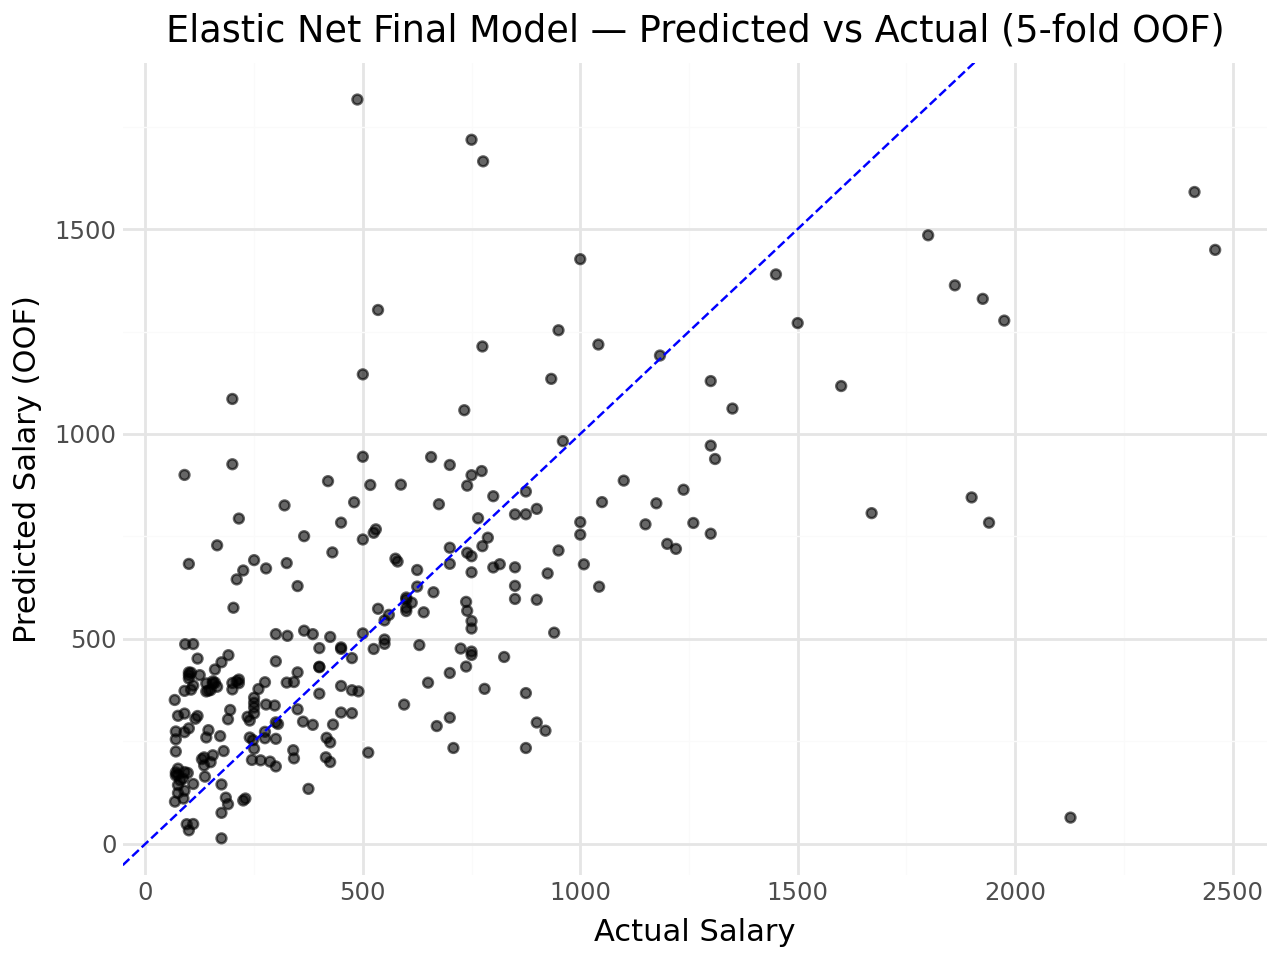

In [89]:
p.show()

In [90]:
ct = best_enet.named_steps["preprocessor"]
feat_names = ct.get_feature_names_out()
coefs = best_enet.named_steps["model"].coef_
coef_df = (
    pd.DataFrame({"Feature": feat_names, "Coefficient": coefs})
    .assign(Abs=lambda d: d["Coefficient"].abs())
    .sort_values("Abs", ascending=False)
)
print("\nTop 10 features by |coefficient| (standardized scale):")
print(coef_df.head(10).to_string(index=False))



Top 10 features by |coefficient| (standardized scale):
        Feature  Coefficient        Abs
      num__Hits   235.849930 235.849930
     num__AtBat  -221.211733 221.211733
     num__CRuns   206.723045 206.723045
    num__CWalks  -147.542803 147.542803
     num__CHits   120.173599 120.173599
cat__Division_W  -118.752469 118.752469
      num__CRBI   116.510017 116.510017
     num__Walks   107.674306 107.674306
    num__CAtBat  -100.889881 100.889881
   num__PutOuts    77.779083  77.779083
